In [1]:
#importing all the necessary modules
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

2.17.0


In [2]:
#defining some constants
IMAGE_SIZE= 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 60

In [3]:
#we are loading the dataset as a 4D Tensor, with shape [batch_size, height, width, channels].
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'leaf_images',
    shuffle = True,
    batch_size= BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
)

Found 9648 files belonging to 8 classes.


In [4]:
len(dataset) #number of batches

302

In [5]:
class_names = dataset.class_names #leaf diseases
class_names

['bacterial_blight',
 'cercospora_leaf_blight',
 'downey_mildew',
 'frogeye',
 'healthy',
 'potassium_deficiency',
 'soybean_rust',
 'target_spot']

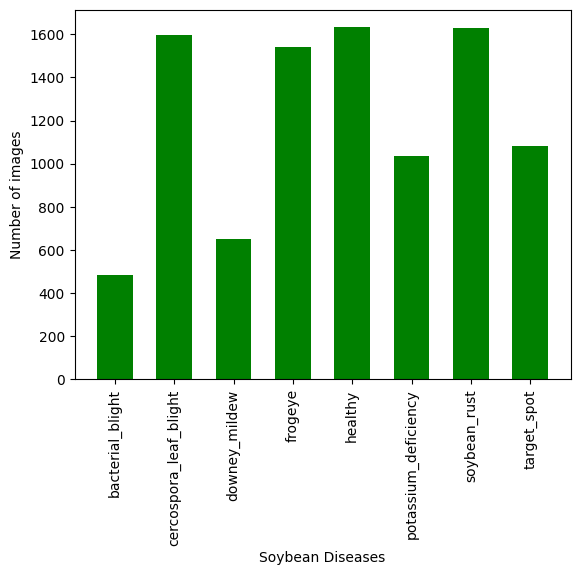

In [6]:
class_quantities = {
    'bacterial_blight' : 484 ,
    'cercospora_leaf_blight' : 1598,
    'downey_mildew' : 652,
    'frogeye' : 1540,
    'healthy' : 1632,
    'potassium_deficiency' : 1034,
    'soybean_rust' : 1627,
    'target_spot' : 1081
}
#plt.figure(figsize = (10,5))
plt.bar(list(class_quantities.keys()), list(class_quantities.values()), color = 'green', width = 0.6)
plt.xlabel("Soybean Diseases")
plt.ylabel("Number of images")
plt.xticks(rotation = 90)
plt.show()

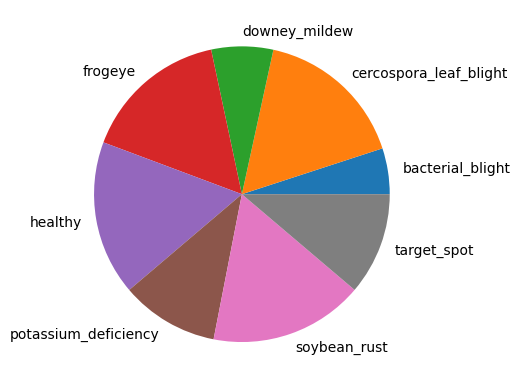

In [7]:
plt.pie(list(class_quantities.values()), labels = list(class_quantities.keys()))
plt.show()

In [8]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape) #shape of the batch of images, a 4D-Tensor
    print(label_batch.numpy()) #labels for our diseases, we convert the tensor into a numpy array
    print(type(label_batch))

(32, 256, 256, 3)
[5 0 2 4 1 1 6 1 4 3 4 0 4 2 1 4 3 7 1 6 6 6 4 3 6 1 0 5 1 7 5 2]
<class 'tensorflow.python.framework.ops.EagerTensor'>


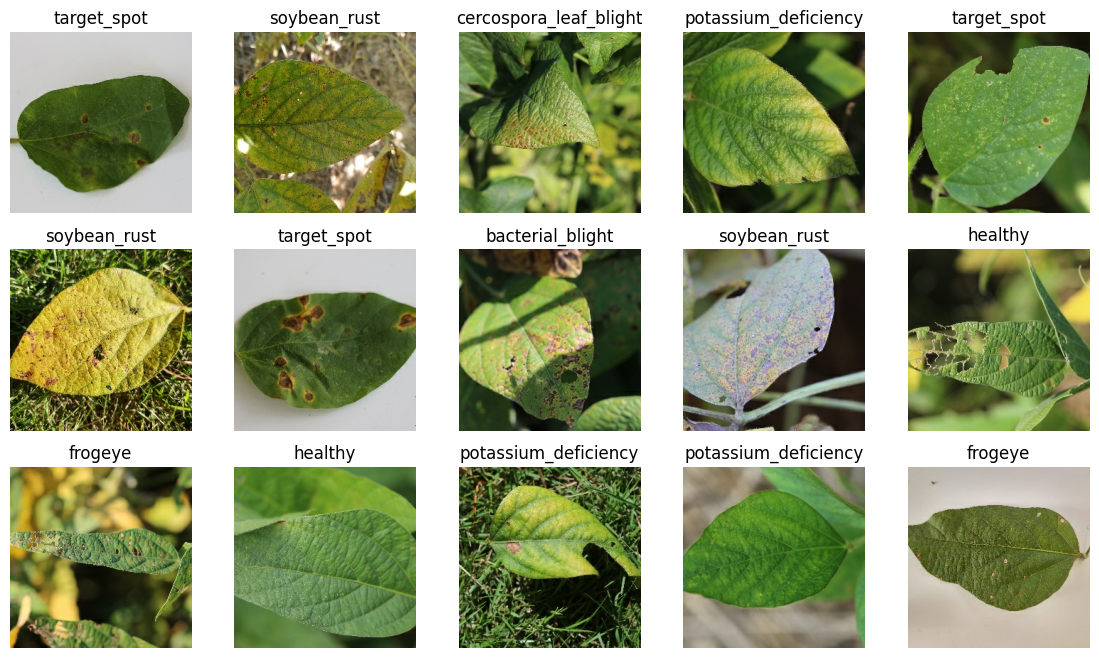

In [9]:
plt.figure(figsize = (14,8))
for batch_of_images, batch_of_labels in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i+1)
        plt.imshow(batch_of_images[i].numpy().astype('uint8')) #we convert the tensor into a numpy array of type 8 bit unsigned int
        plt.title(class_names[batch_of_labels[i]])
        plt.axis("off")

## Splitting the dataset
<p>80% Training data <br>
10% Validation Data<br>
10% Test Data</p>

In [13]:
#we dont have train_test_split in tensors like we do in sci-kit learn, so we define our own function
def get_dataset_partitions_tf(ds, train_split = 0.6, valid_split = 0.2, test_split = 0.2, shuffle = True, shuffle_size = 10000):
    #if shuffle:
        #ds = ds.shuffle(shuffle_size) #you can also give a seed
    ds_size = len(ds)
    train_size = int(len(ds) * train_split)
    valid_size = int(len(ds) * valid_split)
    test_size = int(len(ds) * test_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size + valid_size).take(test_size)

    return train_ds, valid_ds, test_ds

In [14]:
train_ds, valid_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(valid_ds), len(test_ds)

(181, 60, 60)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
#lets define our preprocessing pipeline
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
])

In [16]:
#lets define our data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [17]:
#import tf_keras
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = tf.keras.Sequential([
    layers.InputLayer(input_shape = input_shape), #input_shape is deprecated
    #our data augmentation and resizing and rescaling layers
    data_augmentation,
    resize_and_rescale,

    #defining our convolutional layers
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (256, 256, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),

    #defining our dense layers
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = (None, 256, 256, 3))

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


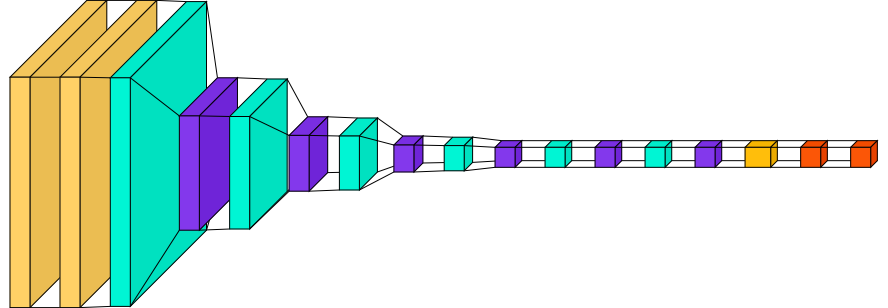

In [18]:
import visualkeras
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'

visualkeras.layered_view(model, spacing=30, color_map = color_map, scale_xy= 0.9)

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,072 (719.03 KB)

 Trainable params: 184,072 (719.03 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy',  # Overall accuracy
        tf.keras.metrics.Precision(),  # Precision
        tf.keras.metrics.Recall(),  # Recall
        tf.keras.metrics.AUC(),  # Area Under the Curve (AUC)
        tf.keras.metrics.MeanSquaredError(),  # Mean Squared Error (MSE)
        tf.keras.metrics.MeanAbsoluteError(),  # Mean Absolute Error (MAE)
        tf.keras.metrics.TopKCategoricalAccuracy(k=5),  # Top 5 accuracy (for multi-class)
    ]
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)

In [21]:
history = model.fit(train_ds, epochs = 1, batch_size = BATCH_SIZE, verbose = 1, validation_data = valid_ds, callbacks = early_stopping)

ValueError: Shape must be rank 1 but is rank 0 for '{{node in_top_k/InTopKV2}} = InTopKV2[T=DT_INT32](sequential_2_1/dense_1_2/Softmax, Cast_26, in_top_k/InTopKV2/k)' with input shapes: [?,8], [], [].

In [76]:
for x,y in train_ds.take(1):
    print(x.numpy())

[[[[198. 205. 215.]
   [197. 204. 214.]
   [198. 205. 215.]
   ...
   [182. 183. 188.]
   [183. 184. 189.]
   [184. 185. 190.]]

  [[200. 207. 217.]
   [199. 206. 216.]
   [199. 206. 216.]
   ...
   [184. 185. 190.]
   [184. 185. 190.]
   [184. 185. 190.]]

  [[201. 208. 218.]
   [201. 208. 218.]
   [201. 208. 218.]
   ...
   [186. 187. 192.]
   [185. 186. 191.]
   [185. 186. 191.]]

  ...

  [[214. 217. 224.]
   [213. 216. 223.]
   [212. 215. 222.]
   ...
   [202. 209. 215.]
   [201. 206. 212.]
   [204. 209. 215.]]

  [[213. 216. 223.]
   [211. 214. 221.]
   [213. 216. 223.]
   ...
   [201. 208. 214.]
   [200. 205. 211.]
   [202. 207. 213.]]

  [[213. 216. 223.]
   [212. 215. 222.]
   [215. 218. 225.]
   ...
   [202. 209. 215.]
   [201. 206. 212.]
   [202. 207. 213.]]]


 [[[ 60. 117.  64.]
   [ 66. 123.  70.]
   [ 73. 130.  77.]
   ...
   [254. 255. 238.]
   [254. 255. 244.]
   [253. 255. 247.]]

  [[ 63. 120.  67.]
   [ 61. 118.  65.]
   [ 57. 114.  63.]
   ...
   [253. 255. 235.]
 

In [31]:
model.save('soy_60_epochs.keras')

In [52]:
scores = model.evaluate(test_ds)
scores

60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9403 - loss: 0.2058


[0.25501757860183716, 0.9322916865348816]

In [33]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation accuracy')

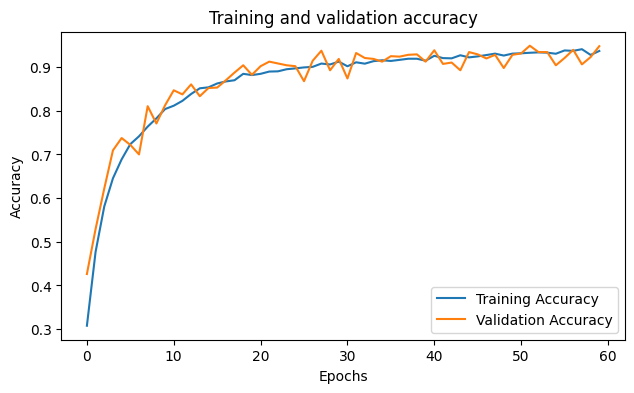

In [36]:
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plt.plot( accu, label = 'Training Accuracy')
plt.plot( val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")

In [35]:
model = tf.keras.models.load_model('soy.keras')

In [46]:
y_actual = tf.constant([], dtype=tf.int32)
for _, labels in test_ds:
    y_actual = tf.concat([y_actual, labels], axis=0)
# Convert final Tensor to NumPy array
y_actual = y_actual.numpy()
print(y_actual)


[5 7 1 ... 3 5 6]


In [47]:
y_pred = model.predict(test_ds)
print(len(y_pred))

60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step
1920


In [48]:
y_pred = np.argmax(np.array(y_pred), axis = 1)

In [49]:
precision = precision_score(y_actual, y_pred, average = 'macro')
recall = recall_score(y_actual, y_pred, average = 'macro')
f1 = f1_score(y_actual, y_pred, average = 'macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
report = classification_report(y_actual, y_pred)
print(report)

Precision: 0.12
Recall: 0.13
F1 Score: 0.13
              precision    recall  f1-score   support

           0       0.03      0.02      0.03        86
           1       0.14      0.12      0.13       311
           2       0.06      0.06      0.06       139
           3       0.18      0.19      0.19       313
           4       0.18      0.19      0.18       354
           5       0.11      0.11      0.11       192
           6       0.19      0.20      0.19       307
           7       0.12      0.11      0.11       218

    accuracy                           0.15      1920
   macro avg       0.12      0.13      0.13      1920
weighted avg       0.14      0.15      0.15      1920



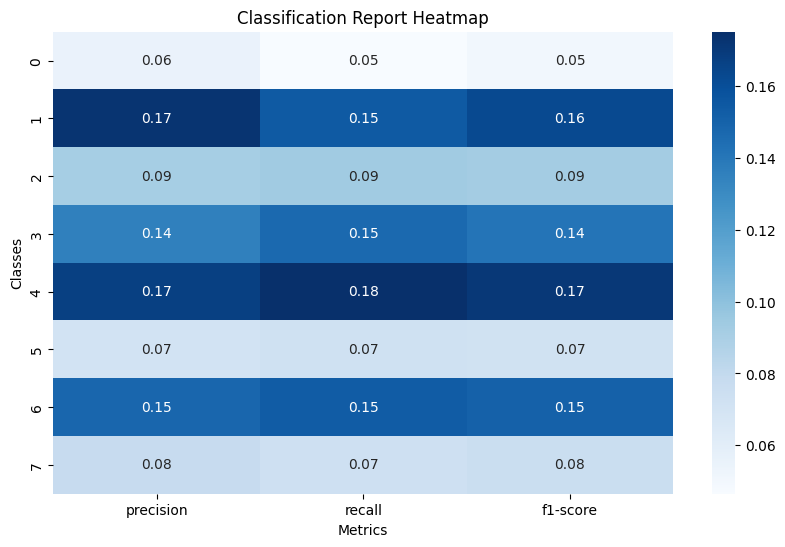

In [45]:
import pandas as pd
import seaborn as sns
report_dict = classification_report(y_actual, y_pred, output_dict=True)

# Convert dictionary to DataFrame for easier visualization
report_df = pd.DataFrame(report_dict).transpose()

# Drop 'accuracy', 'macro avg', and 'weighted avg' for a cleaner heatmap
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap='Blues', fmt=".2f")

# Add labels and title
plt.title('Classification Report Heatmap')
plt.ylabel('Classes')
plt.xlabel('Metrics')
plt.show()

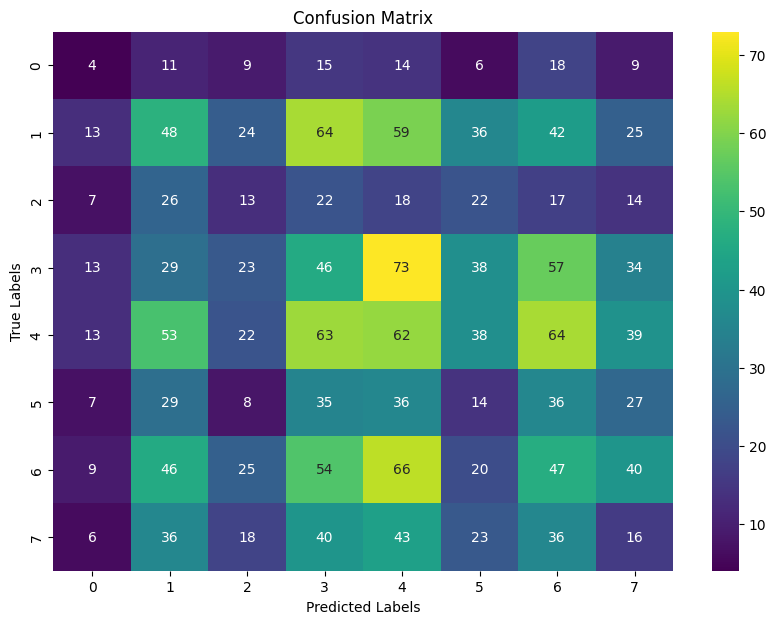

In [41]:
cm = confusion_matrix(y_actual, y_pred)
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [42]:
len(y_actual), len(y_pred)

(1920, 1920)

In [43]:
y_pred

array([6, 1, 3, ..., 1, 1, 1], dtype=int64)